In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys, os

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from recalibration_utils import *
from session_utils import *

import hmm_utils
from hmm import HMMRecalibration
import stabilizer_utils

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from utils.recalibration.RTI_utils import RTI
import itertools
from joblib import Parallel, delayed


plt.rcParams['figure.dpi'] = 300 

participant    = 'T11'
FILE_DIR       = f'{DATA_DIR}/{participant}/'
fig_path      = FIG_DIR
files         = np.asarray(sorted(glob.glob(os.path.join(FILE_DIR, 't11.*/'))))

#block_constraints = getBlockConstraints(FILE_DIR)
#files             = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)

In [2]:
class T11DataStruct(object):
    """
    Generates a simplified R struct from cursor data.
    """
    def __init__(self, file, alignScreens = False, causal_filter = 0):
        
        assert isinstance(file, str), "<file> must be a string"
        assert isinstance(alignScreens, bool), "<alignScreens> must be bool"
        
        self.date = file.split('t11.')[1].split('/')[0]
        
        blocks    = glob.glob(os.path.join(file, 'Block*'))
        self.blockList = list()
        self.gameName  = list()

        self.cursorPos_continuous = list()
        self.targetPos_continuous = list()
        self.decClick_continuous  = list()
        self.blockID_continuous   = list()
        self.TX_continuous = list()
        self.trialEpochs = list()
        self.decVel = list()
        
        
        for block in sorted(blocks):
            # load data files first:
            datafile  = glob.glob(os.path.join(block, 'data.mat'))[0]
            infofile  = glob.glob(os.path.join(block, 'info.mat'))[0]
            taskfile  = glob.glob(os.path.join(block, 'task.mat'))[0]
            
            data = loadmat(datafile)
            info = loadmat(infofile)
            task = loadmat(taskfile)
            
            blockNumber = int(block.split('_')[-1])
            assert blockNumber == int(info['blockNumber'][0][0]), "File block ID and recorded value differ."
            
            self.blockList.append(blockNumber)
            self.blockID_continuous.append(blockNumber * np.ones((info['cursorPos'].shape[0])))
            self.gameName.append(task['name'][0])
            
            self.cursorPos_continuous.append(info['cursorPos'])
            self.targetPos_continuous.append(info['targetPos'])
            
            decClick = np.zeros((info['targetPos'].shape[0]))
            decClick[task['clickInd']] = 1
            self.decClick_continuous.append(decClick)
            self.decVel.append(info['decVel'])
            
            self.TX_continuous.append(data['data'][:, :192].astype(float))
            self.trialEpochs.append(task['startStops'])
            
        for field in ['cursorPos_continuous', 'targetPos_continuous', 'decClick_continuous',
                    'TX_continuous', 'blockID_continuous', 'trialEpochs', 'decVel']:
            setattr(self, field, np.concatenate(getattr(self, field), axis=0))
            
        self.n_trials                = self.trialEpochs.shape[0]
        self.n_channels              = self.TX_continuous.shape[1] 
        self.displacement_continuous = self.targetPos_continuous - self.cursorPos_continuous

        # now load in neural data and smooth if requested:
        if causal_filter > 0:
            self.TX_continuous = firingrate.gaussian_filter1d(self.TX_continuous, sigma = causal_filter, axis = 0, causal = True)
        
        # align screen coordinates across tasks
        self.screenAligned = False
        if alignScreens:
            self.alignTaskScreens()
            self.screenAligned = True
            

    def alignTaskScreens(self):
        '''Realign screen positioning across different tasks into a common reference frame by centering all
           screens at (0, 0). Inputs are:

            struct (DataStruct) - session data to use 
        '''
        
        if not self.screenAligned:
            screen_realignments = np.load('../utils/misc_data/screen_realignments.npy', allow_pickle = True).item()
            
            for i, task in enumerate(self.trialType):
                    self.cursorPos[i] -= screen_realignments[task]
                    self.targetPos[i] -= screen_realignments[task]

            for i, block in enumerate(self.blockList):
                task  = np.unique(self.trialType[self.blockNums == block])
                start = self.trialEpochs[self.blockNums == block, 0].min()

                try:
                    stop = self.trialEpochs[self.blockNums == self.blockList[i+1], 0].min() - 1
                except:
                    stop  = self.trialEpochs[self.blockNums == block, 1].max()

                assert len(task) == 1, "Error: multiple trial types within a block?"

                self.cursorPos_continuous[(start - 1):stop, :] -= screen_realignments[task[0]]
                self.targetPos_continuous[(start - 1):stop, :] -= screen_realignments[task[0]]

        else:
            print('Screens already aligned across tasks. Skipping.')
            
            
def getBlockData(struct, block, field):
    idxs = np.where(struct.blockID_continuous == block)[0]
    return getattr(struct, field)[min(idxs):max(idxs), ...]


def rollingZScore(train_x, test_x, window_size=600, concatenate=False):
    '''Apply moving average z-score based on past time window.'''
    
    train_x_new, test_x_new = list(), list()
    subtract = [train_x[-1]] + test_x

    for i, x in enumerate(train_x):
        pad_val      = np.std(x, axis = 0)
        running_std  = np.std(rolling_window(x, window_size = 600, padding = pad_val), axis = 1) 
        x_rolling    = x / (running_std + 1)
        train_x_new.append(x_rolling)

    for i, x in enumerate(test_x):
        pad_val      = np.std(subtract[i], axis = 0)
        running_std  = np.std(rolling_window(x, window_size = 600, padding = pad_val), axis = 1) 
        x_rolling    = x / (running_std + 1)
        test_x_new.append(x_rolling)
        
    train_x = train_x_new
    test_x  = test_x_new
        
    if concatenate:
        train_x = np.concatenate(train_x)
        test_x  = np.concatenate(test_x) if test_x != [] else []
        
    return train_x, test_x
            
    
def getFoldPerformances(lm, X, y, n_splits):
    scores = list()
    
    x_folds = np.array_split(X, n_splits, axis=0)
    y_folds = np.array_split(y, n_splits, axis=0)

    for x_chunk, y_chunk in zip(x_folds, y_folds):
        scores.append(np.corrcoef(lm.predict(x_chunk).flatten(), y_chunk.flatten())[0, 1])
        
    return scores
    
    
def crossValidatedOracle(X, y, n_splits):
    '''Train a linear regression model on the test split using cross-validation.
    '''
    scores = list()
    
    x_folds = np.array_split(X, n_splits, axis=0)
    y_folds = np.array_split(y, n_splits, axis=0)

    for idx in range(n_splits):
        x_train = np.concatenate([x_folds[i] for i in np.arange(n_splits) if i != idx])
        y_train = np.concatenate([y_folds[i] for i in np.arange(n_splits) if i != idx])
        
        x_test = x_folds[idx]
        y_test = y_folds[idx]
        
        lm = LinearRegression(n_jobs=1).fit(x_train, y_train)
        scores.append(np.corrcoef(lm.predict(x_test).flatten(), y_test.flatten())[0, 1])
        
    return scores


def corrBootstrap(x, y, alpha, n_bootstraps = 10000):
    
    assert x.shape == y.shape, "must be same shape"
    
    idxs  = np.random.choice(x.shape[0], (n_bootstraps, x.shape[0]), replace = True)
    corrs = np.corrcoef(x[idxs].reshape(n_bootstraps, -1), y[idxs].reshape(n_bootstraps, -1))[:n_bootstraps, n_bootstraps:]
    corrs = np.diag(corrs)
    upper = np.percentile(corrs, 100 - (alpha/2))
    lower = np.percentile(corrs, alpha/2)
    
    return lower, upper



def rotateVelocity(intention_vectors, decoder_velocity):
    '''Rotate velocity signals toward target, as in KF ReFIT. Can 
    view as rescaling the intention signal estimates based on ground-truth
    speed as well. Inputs are:
    
        intention_vectors (2D float) - time x 2 of point-to-target signals
        decoded_velocity (2D float)  - time x 2 of ground-truth cursor velocities
        '''
    
    # standardize intention estimates
    intent_norms = np.linalg.norm(intention_vectors, axis=1)
    intention_vectors[intent_norms > 0, :] /= intent_norms[intent_norms > 0][:, None]
    intention_vectors[intent_norms == 0, :] = 0 
    
    # now rescale according to decoded speeds
    intention_vectors *= np.linalg.norm(decoder_velocity, axis=1, keepdims=True)
    
    return intention_vectors


def getPseudolabels(hmm, cursorPos, cursorVel, clickSignal = None, rotate=True):
    '''Returns pseudolabels and weights for PRI-T.'''
    
    viterbi_seq, targStates = hmm.predict([cursorPos], [cursorVel], [clickSignal])
    maxProb                 = np.max(targStates, axis = 1)  # get P(H_i | O_1, ...., O_n)
    inferredTargLoc         = targLocs[viterbi_seq.astype(int), :] 
    pseudolabels            = inferredTargLoc - cursorPos
    
    if rotate:
        pseudolabels = rotateVelocity(pseudolabels, cursorVel)
    
    return pseudolabels, maxProb**2


def parallelSweepRTI(i, j, k):
    look_back = look_back_options[i]
    min_dist  = min_dist_options[j]
    min_time  = min_time_options[k]

    rti                = RTI(look_back, min_dist, min_time)
    rti_x, rti_y, idxs = rti.label(train_x, train_cursor, train_click, return_indices=True)
    rti_y              = rotateVelocity(rti_y, train_vel[idxs]) # rotate cursor to pseudotarget
    lm  = LinearRegression(n_jobs=1).fit(rti_x, rti_y)

    cv_scores = getFoldPerformances(lm, test_x, test_y, n_test_splits)

    return cv_scores, (i,j,k)


def parallelSweepClickPRIT(i,j):

        inflection = inflections[i]
        maxval     = maxvals[j]
        clickProbs = lambda dist : (maxval - 1e-9) * (dist < inflection).astype(float) + 1e-9
        hmm        = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_cfg['vmKappa'], 
                                       adjustKappa, getClickProb=clickProbs)   

        click_pseudolabels, click_maxProb = getPseudolabels(hmm, train_cursor, train_vel, train_click)
        lm                = LinearRegression(n_jobs=1).fit(train_x, click_pseudolabels, sample_weight=click_maxProb)
        median_cv_scores  = np.median(getFoldPerformances(lm, test_x, test_y, n_test_splits))

        return median_cv_scores, (i,j)




First let's load T11's free use data and apply some preprocessing (rolling z-scoring). We'll segment blocks into training (free use) and testing (fitts from end-of-day).

In [3]:
session_blocks = dict()
session_blocks['2021.07.20'] = [[10,13,14,15,16,17,18,20,21,22,24,25], [6,7,8,9]] # day 665
session_blocks['2021.07.27'] = [[6,7,8,9,10,11,12,13,14,15,16],[19,20]]    # day 672 
session_blocks['2021.08.26'] = [[13, 14, 15, 17, 19, 20, 21, 22], [5,6,7]]  # day 702


bad_channels = dict()
bad_channels['2021.07.20'] = None
bad_channels['2021.07.27'] = [81] # = 0 exactly for last 10 min of data (channel failure on hardware end)
bad_channels['2021.08.26'] = None

### Generate figures from processed results

plot performance with increasing dataset size

Processing session /oak/stanford/groups/henderj/ghwilson/nonstationarities/T11/t11.2021.07.20/
38 splits to evaluate for 2021.07.20


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   35.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  7.9min
[Parallel(n_jobs=10)]: Done 862 tasks      | elapsed: 12.0min
[Parallel(n_jobs=10)]: Done 1132 tasks      | elapsed: 16.7min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed: 22.0min
[Parallel(n_jobs=10)]: Done 1500 out of 1500 | elapsed: 22.9min finished
/tmp/ipykernel_24759/3420521496.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarn

Max corr:  0.591114638897168
Inflection: 0.2
maxval: 0.25


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDis

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

2021.07.20 finished. 

Processing session /oak/stanford/groups/henderj/ghwilson/nonstationarities/T11/t11.2021.07.27/
18 splits to evaluate for 2021.07.27


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  6.2min
[Parallel(n_jobs=10)]: Done 862 tasks      | elapsed:  8.5min
[Parallel(n_jobs=10)]: Done 1132 tasks      | elapsed: 11.4min
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/gh

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
/home/users/ghwilson/projects/nonstationarities/note

/home/users/ghwilson/projects/nonstationarities/notebooks/../utils/recalibration/hmm.py:49: RuntimeWarning: invalid value encountered in divide
  normPosErr       = (self.targLocs[:, np.newaxis] - cursorPos) / tDists.T[:, :, np.newaxis]
[Parallel(n_jobs=5)]: Done 220 out of 220 | elapsed: 221.9min finished


2021.07.27 finished. 

Processing session /oak/stanford/groups/henderj/ghwilson/nonstationarities/T11/t11.2021.08.26/
19 splits to evaluate for 2021.08.26


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   37.5s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   54.1s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 862 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 1132 tasks      | elapsed:  6.3min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed:  8.4min
[Parallel(n_jobs=10)]: Done 1500 out of 1500 | elapsed:  8.8min finished
/tmp/ipykernel_24759/3420521496.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  8.4min
[Parallel(n_jobs=5)]: Done  16 out of  20 

Max corr:  0.5360267926249191
Inflection: 0.1
maxval: 0.1


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   52.8s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 160 out of 160 | elapsed: 121.9min finished


2021.08.26 finished. 



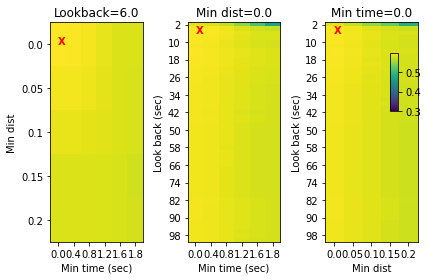

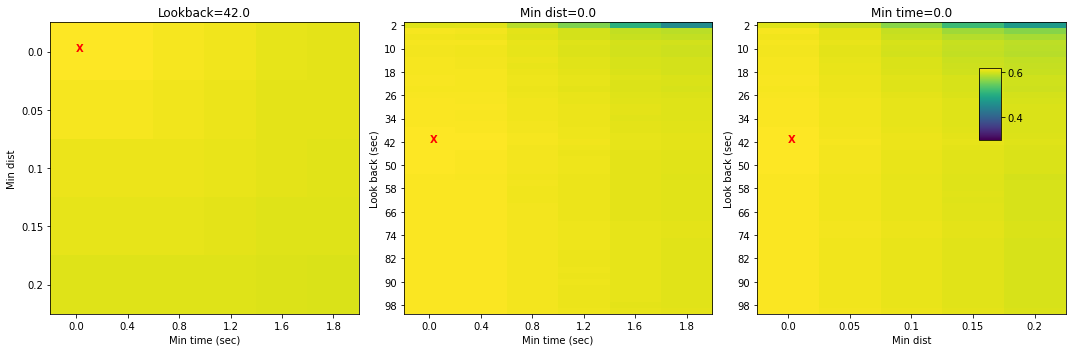

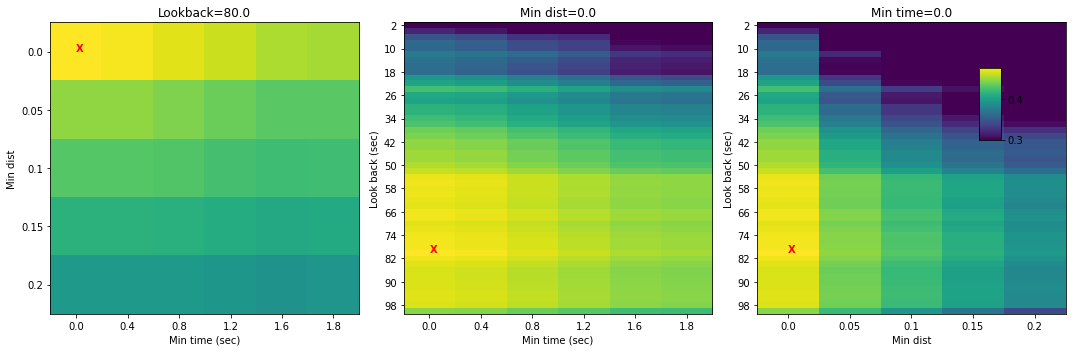

In [4]:
toggle_displacement = True # whether or not to infer displacement or ground-truth decoder outputs
smoothing_sigma     = 10   # smoothing factor
start_from_secs     = 60   # chop off initial X seconds to avoid session start noise
split_length_secs   = 30  # chop timeseries into chunks lasting this long

# RTI HP sweep options
look_back_options = np.concatenate([np.arange(100, 5000, 100), [-1]])
min_dist_options  = np.asarray([0, 0.05, 0.1, 0.15, 0.2])
min_time_options  = np.asarray([0, 20, 40, 60, 80, 90])

# click PRI-T HP sweep options
n_prit_splits = 1 # chop up timeseries so it can be processed faster (parallelized)
inflections   = [0.05, 0.1, 0.15, 0.2]
maxvals       = [0.1, 0.15, 0.2, 0.25, 0.3]

# defaults for regular PRI-T
hmm_cfg  = {'gridSize' : 20, 
            'stayProb' : 0.999, 
            'vmKappa' : 2, 
            'inflection' : 2 * (70 /1200), 
            'exp' : 0.5}
            
            
# where to save data files to
datafiles_dir = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/T11/sweeps/'
            
# -------------------------------------------------
split_length_bins = split_length_secs / 0.02

targLocs                = hmm_utils.getMesh([-1, 1], [-1, 1], gridSize = hmm_cfg['gridSize'])
stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(hmm_cfg['gridSize'], hmm_cfg['stayProb'])
adjustKappa             = lambda dist : 1 / (1 + np.exp(-1 * (dist - hmm_cfg['inflection']) * hmm_cfg['exp']))


for file in files[:3]:
    print(f'Processing session {file}')

    struct = T11DataStruct(file, causal_filter=smoothing_sigma)
    train_blocks, test_blocks = session_blocks[struct.date]

    # neural data preprocessing
    train_x   = [getBlockData(struct, b, 'TX_continuous') for b in train_blocks]
    test_x    = [getBlockData(struct, b, 'TX_continuous') for b in test_blocks]
    train_x, test_x = subtractMeans(train_x, test_x, method = 'rolling', concatenate=False)
    train_x, test_x = rollingZScore(train_x, test_x, concatenate=True)

    # cursor behavior preprocessing
    train_vel = np.concatenate([getBlockData(struct, b, 'decVel') for b in train_blocks])
    test_vel  = np.concatenate([getBlockData(struct, b, 'decVel') for b in test_blocks])
    test_displacement = np.concatenate([getBlockData(struct, b, 'displacement_continuous') for b in test_blocks])

    train_cursor    = np.concatenate([getBlockData(struct, b, 'cursorPos_continuous') for b in train_blocks])
    train_click     = np.concatenate([getBlockData(struct, b, 'decClick_continuous') for b in train_blocks])

    # determine ground-truth signal and also post-processing
    test_y = test_displacement if toggle_displacement else test_vel

    start_from_idx = int(start_from_secs * 50)
    test_y         = test_y[start_from_idx:] # remove very start 
    test_x         = test_x[start_from_idx:] # remove very start

    # remove bad timepoints
    bad_idxs = np.unique(np.where(np.isnan(test_y))[0])
    test_x   = np.delete(test_x, bad_idxs, axis = 0)
    test_y   = np.delete(test_y, bad_idxs, axis = 0)

    # remove bad channels
    if bad_channels[struct.date] is not None:
        train_x = np.delete(train_x, bad_channels[struct.date], axis=1)
        test_x  = np.delete(test_x, bad_channels[struct.date], axis=1)
        
        
    # ======== HP optimizations ========

    n_test_splits  = int(test_x.shape[0] // split_length_bins)
    n_train_splits = int(train_x.shape[0] // split_length_bins)
            
    print(f'{n_test_splits} splits to evaluate for {struct.date}')
    
    # ---- RTI -----
    RTI_HP_sweeps = np.zeros((len(look_back_options), len(min_dist_options), 
                          len(min_time_options), n_test_splits))

    iterator = itertools.product(np.arange(len(look_back_options)), 
                                 np.arange(len(min_dist_options)),
                                 np.arange(len(min_time_options)))

    RTI_sweep   = Parallel(n_jobs=10, verbose = 5)(delayed(parallelSweepRTI)(*idxs) for idxs in iterator)      

    for scores, idxs in RTI_sweep:
        RTI_HP_sweeps[idxs] = scores

    meanvals    = RTI_HP_sweeps.mean(axis=-1)
    rti_HP_idxs = np.unravel_index(np.argmax(meanvals), meanvals.shape)
    
    
    figSize(5, 15)
    fig = plt.figure()

    vmin, vmax = 0.3, meanvals.max()

    plt.subplot(1,3,1)
    plt.imshow(meanvals[rti_HP_idxs[0], :, :], vmin = vmin, vmax= vmax, aspect= 'auto')
    plt.yticks(np.arange(len(min_dist_options)), min_dist_options)
    plt.xticks(np.arange(len(min_time_options)), min_time_options * 0.02)
    plt.xlabel('Min time (sec)')
    plt.ylabel('Min dist')
    plt.text(rti_HP_idxs[2],rti_HP_idxs[1], s= 'X', c = 'r', fontweight='bold')
    plt.title(f'Lookback={look_back_options[rti_HP_idxs[0]] * 0.02}')

    plt.subplot(1,3,2)
    plt.imshow(meanvals[:, rti_HP_idxs[1], :], vmin = vmin, vmax= vmax, aspect='auto')
    plt.yticks(np.arange(len(look_back_options))[::4], (look_back_options * 0.02).astype(int)[::4])
    plt.xticks(np.arange(len(min_time_options)), min_time_options * 0.02)
    plt.xlabel('Min time (sec)')
    plt.ylabel('Look back (sec)')
    plt.text(rti_HP_idxs[2],rti_HP_idxs[0], s= 'X', c = 'r', fontweight='bold')
    plt.title(f'Min dist={min_dist_options[rti_HP_idxs[1]]}')

    plt.subplot(1,3,3)
    plt.imshow(meanvals[:, :, rti_HP_idxs[2]], vmin = vmin, vmax= vmax, aspect='auto')
    plt.yticks(np.arange(len(look_back_options))[::4], (look_back_options * 0.02).astype(int)[::4])
    plt.xticks(np.arange(len(min_dist_options)), min_dist_options)
    plt.xlabel('Min dist')
    plt.ylabel('Look back (sec)')
    plt.text(rti_HP_idxs[1],rti_HP_idxs[0], s= 'X', c = 'r', fontweight='bold')
    plt.title(f'Min time={min_time_options[rti_HP_idxs[2]] * 0.02}')


    cbar_ax = fig.add_axes([.91, .6, .02, .2])
    plt.colorbar(cax=cbar_ax)

    plt.tight_layout()

    save_fname = os.path.join(fig_path, 'T11')
    plt.savefig(os.path.join(save_fname, f'{struct.date}_RTI_HP_sweep.pdf'), format='pdf')
    
            
    # ---- Click PRI-T -----
    split_cursor  = np.array_split(train_cursor, n_prit_splits, axis=0)
    split_vel     = np.array_split(train_vel, n_prit_splits, axis=0)
    split_click   = np.array_split(train_click, n_prit_splits, axis=0)


    iterator = itertools.product(np.arange(len(inflections)), 
                                 np.arange(len(maxvals)),
                                 )

    click_HP_corrs  = np.zeros((len(inflections), len(maxvals) ))
    clickPRIT_sweep = Parallel(n_jobs=5, verbose = 5)(delayed(parallelSweepClickPRIT)(*idxs) for idxs in iterator)

    for scores, idxs in clickPRIT_sweep:
        click_HP_corrs[idxs] = scores

    click_HP_idxs = np.unravel_index(np.argmax(click_HP_corrs), click_HP_corrs.shape)

    print('Max corr: ', click_HP_corrs[click_HP_idxs])
    print('Inflection:',inflections[click_HP_idxs[0]])
    print('maxval:',maxvals[click_HP_idxs[1]])
    click_func = lambda dist : (maxvals[click_HP_idxs[1]] - 1e-9) * (dist < inflections[click_HP_idxs[0]]).astype(float) + 1e-9
            
    # ------------------------

    # build PRI-T model
    hmm       = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_cfg['vmKappa'], 
                                       adjustKappa)  
            
    # build Click PRI-T model with optimal parameters
    click_hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_cfg['vmKappa'], 
                           adjustKappa, getClickProb=click_func)  

    # build RTI with optimal parameters
    lookback  = look_back_options[rti_HP_idxs[0]]
    min_dist  = min_dist_options[rti_HP_idxs[1]] 
    min_time  = min_time_options[rti_HP_idxs[2]] 
    rti       = RTI(lookback, min_dist, min_time)

    def sweepDatasetSizes(i):

        recal_corrs = np.zeros((6, n_test_splits))
        # get past data up to specific timepoint
        if struct.date == '2021.08.26' or struct.date == '2021.07.20': # eval blocks are from start of day
            start         = int((i+1) * split_length_bins)
            subset_x      = train_x[:start]
            subset_cursor = train_cursor[:start]
            subset_vel    = train_vel[:start]
            subset_click  = train_click[:start]

        else: # eval blocks are from end of day
            start         = int(-(i+1) * split_length_bins)
            subset_x      = train_x[start:]
            subset_cursor = train_cursor[start:]
            subset_vel    = train_vel[start:]
            subset_click  = train_click[start:]

        # First fit RTI to data
        rti_x, rti_y, rti_idxs = rti.label(subset_x, subset_cursor, subset_click, return_indices=True)
        rti_y = rotateVelocity(rti_y, subset_vel[rti_idxs]) # perform cursor rotation toward pseudotarget

        lm                   = LinearRegression(n_jobs=1).fit(rti_x, rti_y)
        recal_corrs[0, :] = getFoldPerformances(lm, test_x, test_y, n_test_splits)

        # Now fit PRI-T to only the timesteps used by RTI:
        pseudolabels, weights = getPseudolabels(hmm, subset_cursor, subset_vel)    
        lm                    = LinearRegression(n_jobs=1).fit(subset_x[rti_idxs], pseudolabels[rti_idxs],
                                          sample_weight=weights[rti_idxs])
        recal_corrs[1, :] = getFoldPerformances(lm, test_x, test_y, n_test_splits)

        # now fit PRI-T to all data:
        lm       = LinearRegression(n_jobs=1).fit(subset_x, pseudolabels, sample_weight=weights)
        recal_corrs[2, :] = getFoldPerformances(lm, test_x, test_y, n_test_splits)

        # fit PRI-T without timestep weighting:
        lm       = LinearRegression(n_jobs=1).fit(subset_x, pseudolabels)
        recal_corrs[3, :] = getFoldPerformances(lm, test_x, test_y, n_test_splits)

        # now fit PRI-T with click to all data:
        click_pseudolabels, click_weights = getPseudolabels(click_hmm, subset_cursor, subset_vel, subset_click)    
        lm                 = LinearRegression(n_jobs=1).fit(subset_x, click_pseudolabels, sample_weight=click_weights)
        recal_corrs[4, :]  = getFoldPerformances(lm, test_x, test_y, n_test_splits)

        return recal_corrs


    recal_corrs_list = Parallel(n_jobs=5, verbose = 5)(delayed(sweepDatasetSizes)(i) for i in range(n_train_splits))
    recal_corrs      = np.stack(recal_corrs_list, axis=0)

    # now fit supervised model:
    recal_corrs[:, 5, :] = crossValidatedOracle(test_x, test_y, n_test_splits)

    if not os.path.isdir(datafiles_dir):
        os.makedirs(datafiles_dir)

    save_fname = os.path.join(datafiles_dir, f'{struct.date}_datasize_sweeps.npy')
    np.save(save_fname, recal_corrs)
    print(f'{struct.date} finished. \n')

### Make figures

In [109]:
from scipy.stats import false_discovery_control

def makePairwisePlot(corrs, labels, grp, colors = None, xlim = None, FDR=True):
    """Make pairwise plots of performance on T11 sessions. Inputs are:
    
        corrs (3d float array) : Time x method x replicates of correlations/performance
        labels (1D str)        : labels for each method
        grps (tuple of str)    : subset of labels to plot 
        colors (tuple)         : colors to supply to mpl
        xlim (float or None)   : optional x-axis limit
        FDR (bool)             : false discovery rate control
        
    """
    num_timesteps = corrs.shape[0]
    time_bins     = np.arange(num_timesteps) * 30 / 60
    
    i     = labels.index(grp[0])
    j     = labels.index(grp[1])
    pvals = scipy.stats.wilcoxon(recal_corrs[:, i, :], recal_corrs[:, j, :], axis=1)[1]
        
    # apply FDR correction
    if FDR: pvals = false_discovery_control(pvals, method='by') 

    plt.plot(time_bins, corrs[:,i,:].mean(axis=-1), label = grp[0], c = colors[0], linewidth=3)
    plt.plot(time_bins, corrs[:,j,:].mean(axis=-1), label = grp[1], c = colors[1], linewidth=3)
    plt.scatter(time_bins[pvals < 0.05], np.zeros((sum(pvals < 0.05))), c = 'k')
    
    if xlim is not None: plt.xlim([0,xlim])
    plt.yticks([0, 0.6])
    plt.ylim([-0.1, 0.7])

    plt.xlabel('T11 personal use data (min)')
    plt.ylabel('Corr (r)')
    leg = plt.legend()
    leg.get_frame().set_edgecolor('w')
    
    return pvals

Generate figure 6 main results:

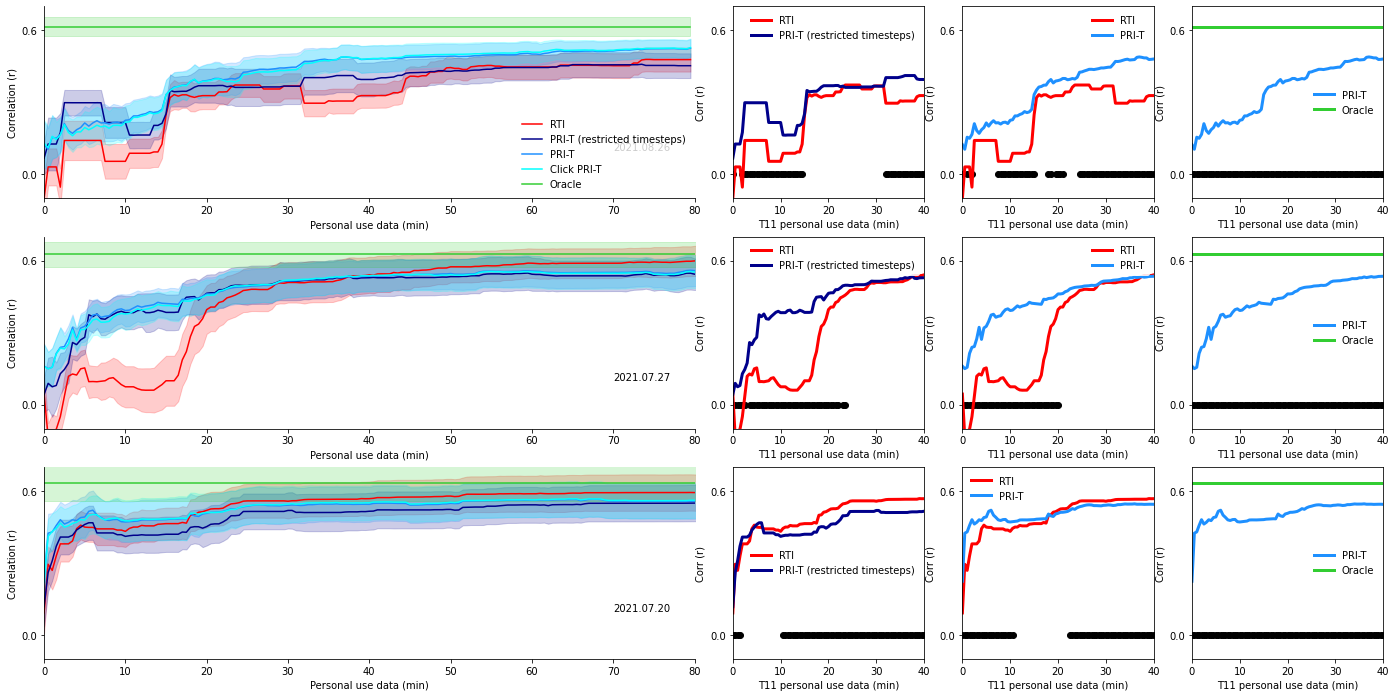

In [118]:
from matplotlib.gridspec import GridSpec



datafiles_dir = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/T11/sweeps/'
labels      = ['RTI', 'PRI-T (restricted timesteps)', 'PRI-T', 'PRI-T (no weighting)', 'Click PRI-T', 'Oracle']
colors      = ['red', 'darkblue',                     'dodgerblue', 'lightblue',       'cyan',        'limegreen']


fig = plt.figure(figsize=(24,12))
gs  = GridSpec(3,6, figure=fig)


for idx, file in enumerate(files[:3][::-1]):
    date        = file.split('t11.')[1].split('/')[0]
    fname       = os.path.join(datafiles_dir, f'{date}_datasize_sweeps.npy')
    recal_corrs = np.load(fname)
    n_splits    = recal_corrs.shape[0]
    
    
    ax = fig.add_subplot(gs[idx, :3])
        
    time_bins = np.arange(n_splits) * 30 / 60
    for i in range(len(labels)):
        if labels[i] != 'PRI-T (no weighting)':
            plotsd(recal_corrs[:, i, :].T, time_bins= time_bins,
                   color = colors[i], label = labels[i], toggleSE=False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel('Correlation (r)')
    plt.xlabel('Personal use data (min)')
    if idx == 0:
        leg = plt.legend()
        leg.get_frame().set_edgecolor('w')
    plt.xlim([0,80])
    plt.yticks([0, 0.6])
    plt.ylim([-0.1, 0.7])
    plt.text(70, 0.1, date)
    
    
    # side plots 
    grps = [
    ['RTI', 'PRI-T (restricted timesteps)'],
    ['RTI', 'PRI-T'],
    ['PRI-T', 'Oracle'],
    ]
    colors = ['red', 'darkblue', 'dodgerblue', 'lightblue', 'cyan', 'limegreen']

    for idx2, grp in enumerate(grps):
        ax = fig.add_subplot(gs[idx, 3 + idx2])
        plt_colors = [colors[labels.index(g)] for g in grp]
        makePairwisePlot(recal_corrs, labels, grp, plt_colors, xlim=40, FDR=True)    
    
    
save_fname = os.path.join(fig_path, 'T11')
if not os.path.isdir(save_fname):
    os.makedirs(save_fname)
plt.savefig(os.path.join(save_fname, f'figure6_sweep'), format='pdf')    

Supplementary data:

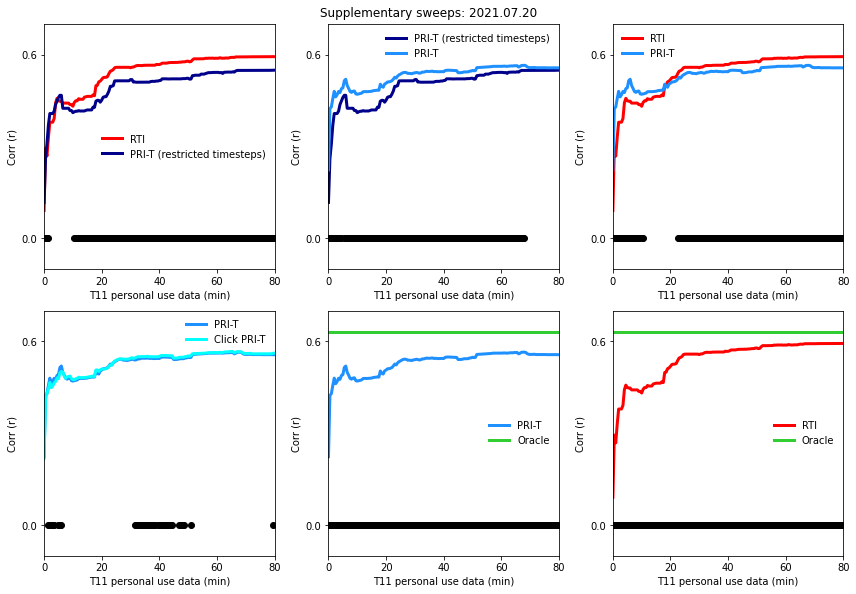

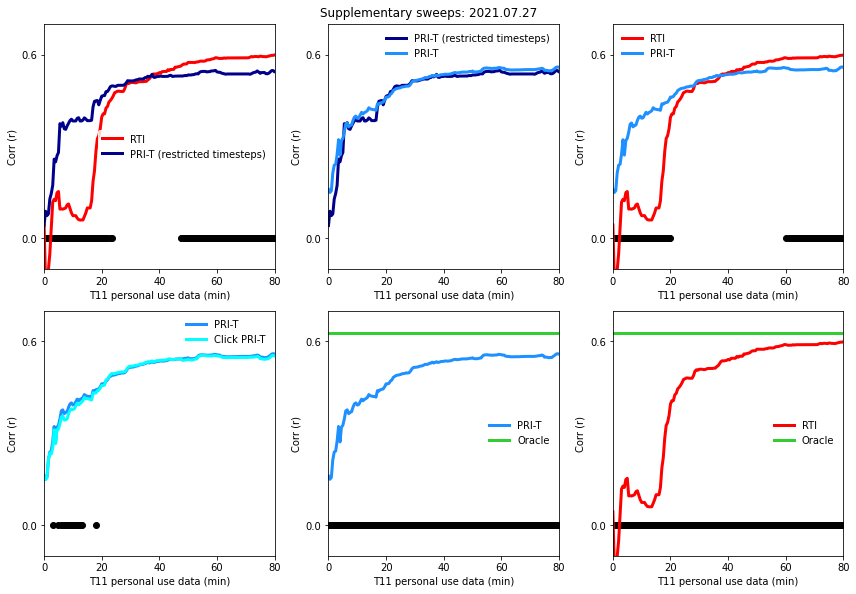

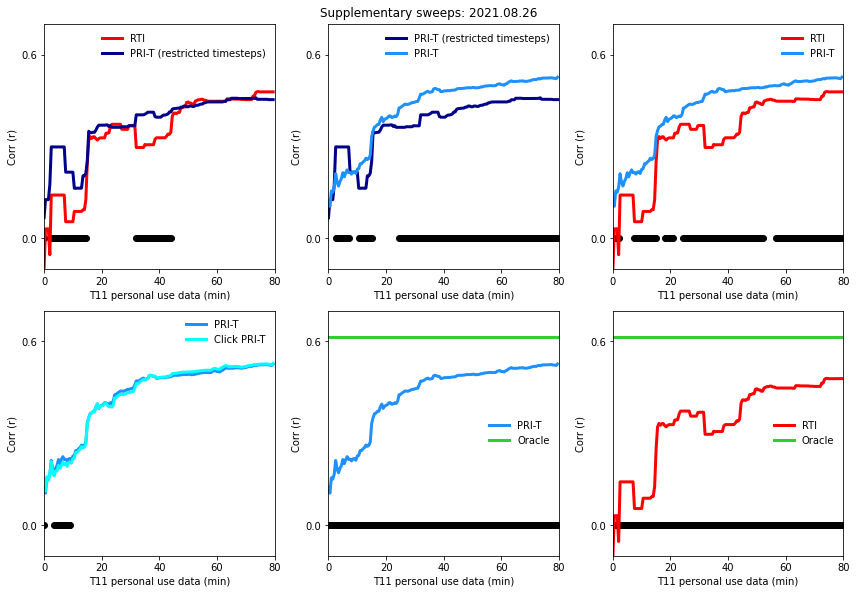

In [119]:
# Generate supplementary figure files 

for idx, file in enumerate(files[:3]):
    date        = file.split('t11.')[1].split('/')[0]
    fname       = os.path.join(datafiles_dir, f'{date}_datasize_sweeps.npy')
    recal_corrs = np.load(fname)
    n_splits    = recal_corrs.shape[0]


    plt.figure(figsize=(12,12))
    grps = [
        ['RTI', 'PRI-T (restricted timesteps)'],
        ['PRI-T (restricted timesteps)', 'PRI-T'],
        ['RTI', 'PRI-T'],
        ['PRI-T', 'Click PRI-T'],
        ['PRI-T', 'Oracle'],
        ['RTI', 'Oracle'],
    ]

    for idx2, grp in enumerate(grps):
        plt.subplot(3,3,idx2+1)
        plt_colors = [colors[labels.index(g)] for g in grp]
        makePairwisePlot(recal_corrs, labels, grp, plt_colors, xlim=80)

    plt.suptitle(f'Supplementary sweeps: {date}')
    plt.tight_layout()
    
    save_fname = os.path.join(fig_path, 'T11')
    if not os.path.isdir(save_fname):
        os.makedirs(save_fname)
    plt.savefig(os.path.join(save_fname, f'{date}_dataset_sweep_pvals'), format='pdf')


no_weighting subpanel:

In [128]:
plt.figure(figsize=(12,12))
grps = [
    ['PRI-T (no weighting)', 'PRI-T'],
    ['PRI-T (no weighting)', 'RTI'],
    ['PRI-T (no weighting)', 'Oracle'],
]

<Figure size 864x864 with 0 Axes>

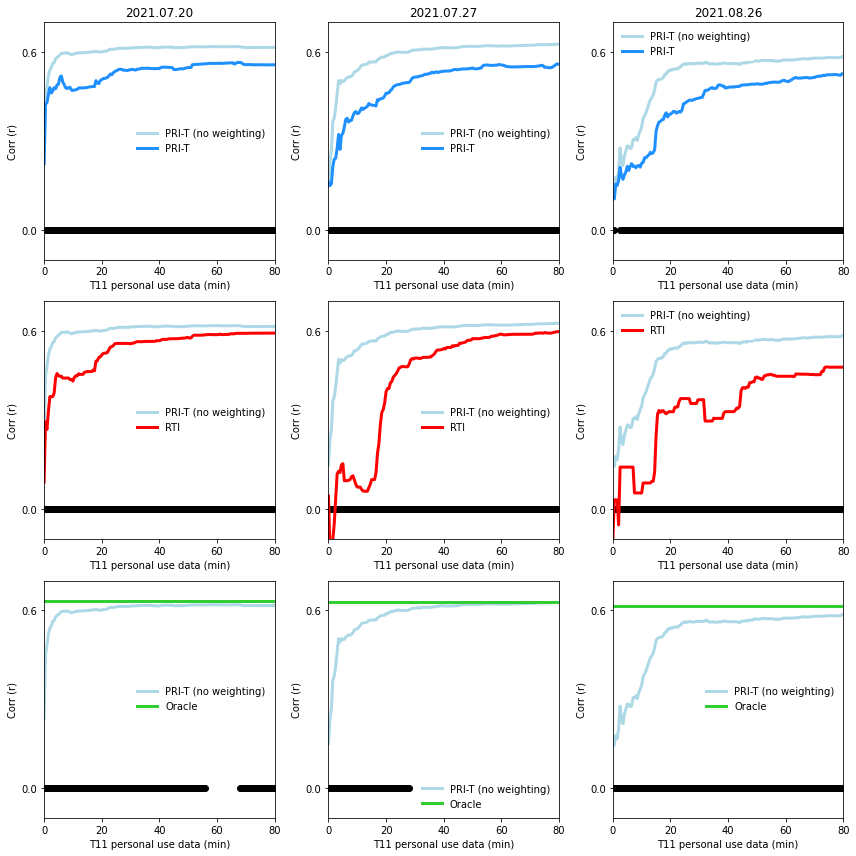

In [135]:
fig = plt.figure(figsize=(12,12))
gs  = GridSpec(3,3, figure=fig)

for idx, file in enumerate(sorted(files[:3])):
    date        = file.split('t11.')[1].split('/')[0]
    fname       = os.path.join(datafiles_dir, f'{date}_datasize_sweeps.npy')
    recal_corrs = np.load(fname)
    n_splits    = recal_corrs.shape[0]

    
    for idx2, grp in enumerate(grps):
        ax = fig.add_subplot(gs[idx2, idx])
        plt_colors = [colors[labels.index(g)] for g in grp]
        makePairwisePlot(recal_corrs, labels, grp, plt_colors, xlim=80, FDR=True)
        if idx2 == 0: plt.title(date)

    plt.tight_layout()
    
save_fname = os.path.join(fig_path, 'T11')
if not os.path.isdir(save_fname):
    os.makedirs(save_fname)
plt.savefig(os.path.join(save_fname, f'noweighting_sweep'), format='pdf')
